# Source Kernel
This kernel generates and submits a prediction using the model: ["LightGBM on GPU with Feature Engineering, Optuna, and , Visualization"](https://github.com/satorushibata0627/Publishment/blob/main/Kaggle_Python3_LightGBM_on_GPU_with_Feature_Engineering_Optuna_and_Visualization.ipynb).

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import gc
from tqdm.notebook import tqdm
import riiideducation

# Load the model and parameters.

In [2]:
model = pd.read_pickle('../input/the-best-of-model-on-lightgbm/The_best_of_model_on_LightGBM.pickle')
print('model loaded')

model loaded


In [3]:
params = pd.read_pickle('../input/the-best-of-all-parameters-on-lightgbm/The_best_of_all_parameters_on_LightGBM.pickle')
print('Parameters:', params)

Parameters: {'objective': 'binary', 'metric': 'AUC', 'boosting_type': 'dart', 'lambda_l1': 0.11438196901237276, 'lambda_l2': 0.44167065682241313, 'num_leaves': 33, 'feature_fraction': 0.4286499111129028, 'bagging_fraction': 0.8650204850463731, 'bagging_freq': 1, 'min_child_samples': 98}


# Setting
CV files are generated by [this notebook](https://www.kaggle.com/its7171/cv-strategy)

In [4]:
train_pickle  = '../input/riiid-cross-validation-files/cv1_train.pickle'
valid_pickle  = '../input/riiid-cross-validation-files/cv1_valid.pickle'
question_file = '../input/riiid-test-answer-prediction/questions.csv'

# Feature engineering

In [5]:
# funcs for user stats with loop
def add_user_feats(df, answered_correctly_sum_u_dict, count_u_dict):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    for cnt,row in enumerate(tqdm(df[['user_id','answered_correctly']].values)):
        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
        answered_correctly_sum_u_dict[row[0]] += row[1]
        count_u_dict[row[0]] += 1
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    return df

def add_user_feats_without_update(df, answered_correctly_sum_u_dict, count_u_dict):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    for cnt,row in enumerate(df[['user_id']].values):
        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    return df

def update_user_feats(df, answered_correctly_sum_u_dict, count_u_dict):
    for row in df[['user_id','answered_correctly','content_type_id']].values:
        if row[2] == 0:
            answered_correctly_sum_u_dict[row[0]] += row[1]
            count_u_dict[row[0]] += 1

In [6]:
# read data
feld_needed = ['row_id', 'user_id', 'content_id', 'content_type_id', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation']
train = pd.read_pickle(train_pickle)[feld_needed]
valid = pd.read_pickle(valid_pickle)[feld_needed]
train = train.loc[train.content_type_id == False].reset_index(drop=True)
valid = valid.loc[valid.content_type_id == False].reset_index(drop=True)

# answered correctly average for each content
content_df = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean']).reset_index()
content_df.columns = ['content_id', 'answered_correctly_avg_c']
train = pd.merge(train, content_df, on=['content_id'], how="left")
valid = pd.merge(valid, content_df, on=['content_id'], how="left")

# user stats features with loops
answered_correctly_sum_u_dict = defaultdict(int)
count_u_dict = defaultdict(int)
train = add_user_feats(train, answered_correctly_sum_u_dict, count_u_dict)
valid = add_user_feats(valid, answered_correctly_sum_u_dict, count_u_dict)

# fill with mean value for prior_question_elapsed_time
# note that `train.prior_question_elapsed_time.mean()` dose not work!
# please refer https://www.kaggle.com/its7171/can-we-trust-pandas-mean for detail.
prior_question_elapsed_time_mean = train.prior_question_elapsed_time.dropna().values.mean()
train['prior_question_elapsed_time_mean'] = train.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
valid['prior_question_elapsed_time_mean'] = valid.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)

# use only last 30M training data for limited memory on kaggle env.
#train = train[-30000000:]

# part
questions_df = pd.read_csv(question_file)
train = pd.merge(train, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')
valid = pd.merge(valid, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')

# changing dtype to avoid lightgbm error
train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')
valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')

In [7]:
TARGET = 'answered_correctly'
FEATS = ['answered_correctly_avg_u', 'answered_correctly_sum_u', 'count_u', 'answered_correctly_avg_c', 'part', 'prior_question_had_explanation', 'prior_question_elapsed_time']
dro_cols = list(set(train.columns) - set(FEATS))
y_tr = train[TARGET]
y_va = valid[TARGET]
train.drop(dro_cols, axis=1, inplace=True)
valid.drop(dro_cols, axis=1, inplace=True)
_=gc.collect()

# Inference

In [8]:
class Iter_Valid(object):
    def __init__(self, df, max_user=1000):
        df = df.reset_index(drop=True)
        self.df = df
        self.user_answer = df['user_answer'].astype(str).values
        self.answered_correctly = df['answered_correctly'].astype(str).values
        df['prior_group_responses'] = "[]"
        df['prior_group_answers_correct'] = "[]"
        self.sample_df = df[df['content_type_id'] == 0][['row_id']]
        self.sample_df['answered_correctly'] = 0
        self.len = len(df)
        self.user_id = df.user_id.values
        self.task_container_id = df.task_container_id.values
        self.content_type_id = df.content_type_id.values
        self.max_user = max_user
        self.current = 0
        self.pre_user_answer_list = []
        self.pre_answered_correctly_list = []

    def __iter__(self):
        return self
    
    def fix_df(self, user_answer_list, answered_correctly_list, pre_start):
        df= self.df[pre_start:self.current].copy()
        sample_df = self.sample_df[pre_start:self.current].copy()
        df.loc[pre_start,'prior_group_responses'] = '[' + ",".join(self.pre_user_answer_list) + ']'
        df.loc[pre_start,'prior_group_answers_correct'] = '[' + ",".join(self.pre_answered_correctly_list) + ']'
        self.pre_user_answer_list = user_answer_list
        self.pre_answered_correctly_list = answered_correctly_list
        return df, sample_df

    def __next__(self):
        added_user = set()
        pre_start = self.current
        pre_added_user = -1
        pre_task_container_id = -1
        pre_content_type_id = -1
        user_answer_list = []
        answered_correctly_list = []
        while self.current < self.len:
            crr_user_id = self.user_id[self.current]
            crr_task_container_id = self.task_container_id[self.current]
            crr_content_type_id = self.content_type_id[self.current]
            if crr_user_id in added_user and (crr_user_id != pre_added_user or (crr_task_container_id != pre_task_container_id and crr_content_type_id == 0 and pre_content_type_id == 0)):
                # known user(not prev user or (differnt task container and both question))
                return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            if len(added_user) == self.max_user:
                if  crr_user_id == pre_added_user and (crr_task_container_id == pre_task_container_id or crr_content_type_id == 1):
                    user_answer_list.append(self.user_answer[self.current])
                    answered_correctly_list.append(self.answered_correctly[self.current])
                    self.current += 1
                    continue
                else:
                    return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            added_user.add(crr_user_id)
            pre_added_user = crr_user_id
            pre_task_container_id = crr_task_container_id
            pre_content_type_id = crr_content_type_id
            user_answer_list.append(self.user_answer[self.current])
            answered_correctly_list.append(self.answered_correctly[self.current])
            self.current += 1
        if pre_start < self.current:
            return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
        else:
            raise StopIteration()

# Predict and submit the result.

In [9]:
# To predict
env = riiideducation.make_env()
iter_test = env.iter_test()
set_predict = env.predict

# Empirical analysis
## [Bootstrap](https://qiita.com/katsu1110/items/23b8a37ac400dd0eaad2#%E3%83%96%E3%83%BC%E3%83%88%E3%82%B9%E3%83%88%E3%83%A9%E3%83%83%E3%83%97%E3%81%A8%E3%81%AF)

In [10]:
# Bootstrap to compute sem of the median
def bootstrap(x, repeats):
    iq = x
    # compute mean, SEM (standard error of the mean) and median
    mean_iq = np.average(iq)
    sem_iq = np.std(iq)/np.sqrt(len(iq))
    median_iq = np.median(iq)
    # placeholder (column1: mean, column2: median)
    vec = np.zeros((2,repeats))
    for i in np.arange(repeats):
        # resample data with replacement
        re = np.random.choice(len(x),len(x),replace=True)
        re_x = x[re]

        # compute mean and median of the "new" dataset
        vec[0,i] = np.mean(re_x)
        vec[1,i] = np.median(re_x)

    # histogram of median from resampled datasets
    sns.distplot(vec[1,:], kde=False)

    # compute bootstrapped standard error of the mean,
    # and standard error of the median
    b_mean_sem = np.std(vec[0,:])
    b_median_sem = np.std(vec[1,:])

    return b_mean_sem, b_median_sem 

Operation completed.
Operation completed.
Operation completed.
Operation completed.


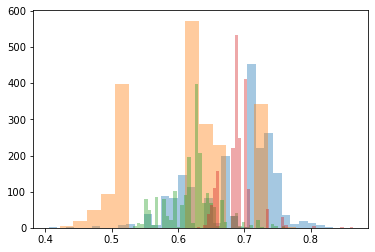

In [11]:
previous_test_df = None
for (test_df, sample_prediction_df) in iter_test:
    if previous_test_df is not None:
        previous_test_df[TARGET] = eval(test_df["prior_group_answers_correct"].iloc[0])
        update_user_feats(previous_test_df, answered_correctly_sum_u_dict, count_u_dict)
    previous_test_df = test_df.copy()
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = add_user_feats_without_update(test_df, answered_correctly_sum_u_dict, count_u_dict)
    test_df = pd.merge(test_df, content_df, on='content_id',  how="left")
    test_df = pd.merge(test_df, questions_df, left_on='content_id', right_on='question_id', how='left')
    test_df['prior_question_had_explanation'] = test_df.prior_question_had_explanation.fillna(False).astype('int8')
    test_df['prior_question_elapsed_time_mean'] = test_df.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
    # Prediction with LightGBM.
    test_df[TARGET] = model.predict(test_df[FEATS])
    # Execute Bootstrap
    bootstrap(np.array(test_df['answered_correctly']), 2000) 
    # Submit
    set_predict(test_df[['row_id', TARGET]])
    print('Operation completed.')